Some weights of BertForSequenceClassification were not initialized from the model checkpoint at beomi/kcbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



📊 [화자별 예측 결과 요약]

🧑 김소연
- elder_speech(어르신 말투): 1 문장 (4.35%)
- soft_polite(부드럽고 상냥한 말투): 3 문장 (13.04%)
- chat_emoticon(이모티콘 자주 쓰는 말투): 15 문장 (65.22%)
- informal(친근한 말투): 2 문장 (8.70%)
- formal(격식있는 말투): 2 문장 (8.70%)

🧑 유정유정
- chat_emoticon(이모티콘 자주 쓰는 말투): 20 문장 (68.97%)
- informal(친근한 말투): 5 문장 (17.24%)
- formal(격식있는 말투): 2 문장 (6.90%)
- soft_polite(부드럽고 상냥한 말투): 2 문장 (6.90%)


/var/folders/v9/2ktpgbm972z8k5m79m3kldbw0000gn/T/ipykernel_30532/331838083.py:94: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) AppleGothic.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


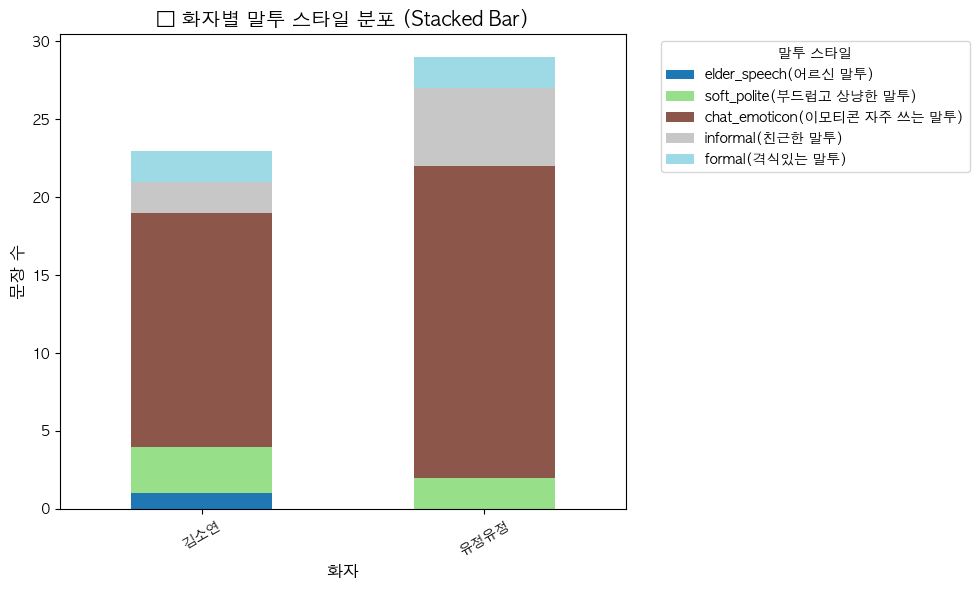

In [4]:
# ✅ 1. 기본 import
import sys
import os
import importlib
import torch
sys.path.append(os.path.join(os.getcwd(), "전처리"))
import merge
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from peft import PeftModel
from collections import defaultdict

plt.rcParams['font.family'] = 'AppleGothic'

# ✅ 2. merge.py 실행

import merge  # 전처리 모듈 불러오기

# ✅ 카톡 파일 지정 (변경 가능)
input_chat_path = "datasets/KakaoTalk_20250515_0053_22_930_유정유정.txt"

# ✅ merge 실행 → 정제된 문장 리스트 반환
clean_sentences = merge.run_merge(input_chat_path)  # run_merge() 함수가 merge.py에 있다고 가정

# ✅ 3. 모델 로드
ADAPTER_PATH = "Models/ToneDetect_adapter"
BASE_MODEL_NAME = "beomi/kcbert-base"  # 원래 학습할 때 사용한 베이스

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME)
base_model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL_NAME, num_labels=5)
model = PeftModel.from_pretrained(base_model, ADAPTER_PATH)
model.eval()

# ✅ 4. 예측 함수
def predict_style(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        pred_class = torch.argmax(logits, dim=1).item()
    return pred_class

# ✅ 5. 라벨 정의
label_map = {
    0: "chat_emoticon(이모티콘 자주 쓰는 말투)",
    1: "elder_speech(어르신 말투)",
    2: "formal(격식있는 말투)",
    3: "informal(친근한 말투)",
    4: "soft_polite(부드럽고 상냥한 말투)"
}

# ✅ speaker 별 style_counts 초기화
speaker_style_counts = defaultdict(lambda: defaultdict(int))
clean_sentences = merge.run_merge(input_chat_path)

# ✅ 각 문장 예측
for msg in clean_sentences:
    speaker = msg['speaker']
    text = msg['text']
    pred = predict_style(text)
    style_name = label_map[pred]
    speaker_style_counts[speaker][style_name] += 1

# ✅ 결과 출력
print("\n📊 [화자별 예측 결과 요약]")
for speaker, style_counts in speaker_style_counts.items():
    print(f"\n🧑 {speaker}")
    total = sum(style_counts.values())
    for style, count in style_counts.items():
        percent = count / total * 100
        print(f"- {style}: {count} 문장 ({percent:.2f}%)")

# ✅ 8. 시각화 (화자별 stacked bar chart 예시)
import pandas as pd

# DataFrame으로 변환
data = []
for speaker, style_counts in speaker_style_counts.items():
    row = {'speaker': speaker}
    row.update(style_counts)
    data.append(row)

df = pd.DataFrame(data).fillna(0)
df.set_index('speaker', inplace=True)

# 시각화
df.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20')
plt.title("📊 화자별 말투 스타일 분포 (Stacked Bar)", fontsize=14)
plt.xlabel("화자", fontsize=12)
plt.ylabel("문장 수", fontsize=12)
plt.xticks(rotation=30)
plt.legend(title='말투 스타일', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [5]:
print(merge.run_merge)  # 지금 어떤 함수가 로드됐는지 확인
print(type(clean_sentences[0]))  # dict 인지, string 인지 확인

<function run_merge at 0x175e6bd80>
<class 'dict'>
